In [1]:
import pandas as pd  
import matplotlib.pyplot as plt

In [2]:
# CREATING A DATAFRAME WITH POPULATION COUNT FOR EACH BLOCK


drop_cols_pop = ["NAME", "Unnamed: 73"]
drop_cols_pop += [f"P001{str(i).zfill(3)}" for i in range(2, 72)]

states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA","HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD","MA", "MI", "MN", "MS", "MO", "MT", 
          "NE", "NV", "NH", "NJ","NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC","SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", "DC"]

pops = []
for state in states:
    path = f"..\\data\\population\\population_{state}.csv"
    state_df = pd.read_csv(
        path,
        low_memory=False,
        usecols=lambda col: col not in drop_cols_pop
    )
    state_df = state_df.iloc[1:].reset_index(drop=True)
    state_df["BlockCode"] = state_df["GEO_ID"].astype(str).str[-15:]
    pops.append(state_df)
pop = pd.concat(pops, ignore_index=True)

print(pop.head()) 

                     GEO_ID P001001        BlockCode
0  1000000US010010201001000      61  010010201001000
1  1000000US010010201001001       0  010010201001001
2  1000000US010010201001002       0  010010201001002
3  1000000US010010201001003      75  010010201001003
4  1000000US010010201001004       0  010010201001004


In [ ]:
# CREATING A DATAFRAME WITH INTERNET SPEED FOR EACH BLOCK - DEC 2014


chunks = pd.read_csv(r'..\data\broadband\fixed_satellite_dec_2014.csv', encoding='latin1', chunksize=250000, low_memory=False, usecols=lambda col: col not in ["LogRecNo", "StateAbbr", "Provider_Id", "ProviderName", "HoldingCompanyName", "HocoFinal"])
processed_chunks = []
for chunk in chunks:
    chunk['Date'] = '2015'
    chunk['CountyCode'] = chunk['BlockCode'].astype(str).str[:5]
    processed_chunks.append(chunk)
df = pd.concat(processed_chunks, ignore_index=True)
df.to_csv(r'..\data\broadband\block_bb_2015.csv', index=False)

In [3]:
block_bb_2015 = pd.read_csv(r'..\data\broadband\block_bb_2015.csv', encoding='latin1')

In [4]:
# CREATING A DATAFRAME WITH A BROADBAND DUMMY FOR EACH BLOCK - DEC 2014


block_bb_2015['broadband_provision'] = (block_bb_2015['MaxAdDown'] >= 100) & (block_bb_2015['MaxAdUp'] >= 20)
block_bb_2015['broadband_block'] = block_bb_2015.groupby('BlockCode')['broadband_provision'].transform('any').astype(int)
blocks_bb_2015_provision = block_bb_2015.drop_duplicates(subset='BlockCode')[['BlockCode', 'broadband_block', 'Date', 'CountyCode']]
blocks_bb_2015_provision['BlockCode'] = blocks_bb_2015_provision['BlockCode'].astype(str).str.zfill(15)

print(blocks_bb_2015_provision.head())  
print(len(pop))
print(len(blocks_bb_2015_provision)) 
print(blocks_bb_2015_provision['broadband_block'].sum())

         BlockCode  broadband_block  Date  CountyCode
0  410430301001053                1  2015       41043
1  410430302003099                0  2015       41043
2  410430302003126                0  2015       41043
3  410430302003153                0  2015       41043
4  410430302003154                0  2015       41043
11078297
10852585
2948210


In [5]:
# MERGING THE POPULATION AND DUMMY DATAFRAMES - DEC 2014


county_bb_2015 = pop.merge(blocks_bb_2015_provision, on='BlockCode', how='left')

print(county_bb_2015.head())  
print(len(county_bb_2015)) 

                     GEO_ID P001001        BlockCode  broadband_block    Date  \
0  1000000US010010201001000      61  010010201001000              0.0  2015.0   
1  1000000US010010201001001       0  010010201001001              0.0  2015.0   
2  1000000US010010201001002       0  010010201001002              0.0  2015.0   
3  1000000US010010201001003      75  010010201001003              0.0  2015.0   
4  1000000US010010201001004       0  010010201001004              0.0  2015.0   

   CountyCode  
0     10010.0  
1     10010.0  
2     10010.0  
3     10010.0  
4     10010.0  
11078297


C:\Users\HP\AppData\Local\Temp\ipykernel_14904\749592272.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  county_bb_2015_provision = county_bb_2015.groupby('CountyCode').apply(


   CountyCode  county_provision
0     10001.0          0.947532
1     10003.0          0.980826
2     10005.0          0.932461
3     10010.0          0.000000
4     10030.0          0.716457
3197
0.061723559037493006
1056


(array([1714.,  182.,  143.,  121.,  117.,  146.,  156.,  153.,  150.,
         315.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

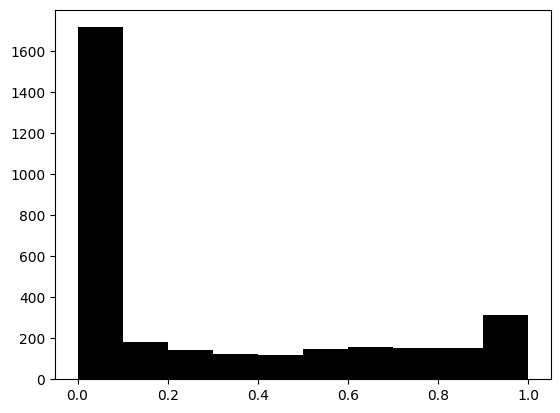

In [6]:
# CREATING A DATAFRAME WITH A MEASURE OF BRODBAND AVAILABILITY FOR EACH COUNTY - DEC 2014


county_bb_2015['P001001'] = pd.to_numeric(county_bb_2015['P001001'], errors='coerce')
county_bb_2015_provision = county_bb_2015.groupby('CountyCode').apply(
    lambda x: pd.Series({
        'county_provision': (x['P001001'] * x['broadband_block']).sum() / x['P001001'].sum()
        if x['P001001'].sum() > 0 else 0
    })
).reset_index()

print(county_bb_2015_provision.head())  
print(len(county_bb_2015_provision)) 
print(county_bb_2015_provision['county_provision'].median())
print((county_bb_2015_provision['county_provision'] == 0).sum())
plt.hist(county_bb_2015_provision['county_provision'], color='black')

In [7]:
county_bb_2015_provision.to_csv(r'..\data\broadband\county_bb_2015.csv', index=False)

In [ ]:
# CREATING A DATAFRAME WITH INTERNET SPEED FOR EACH BLOCK - JUN 2015


chunks = pd.read_csv(r'..\data\broadband\fixed_satellite_jun_2015.csv', encoding='latin1', chunksize=250000, low_memory=False, usecols=lambda col: col not in ["LogRecNo", "StateAbbr", "Provider_Id", "ProviderName", "HoldingCompanyName", "HocoFinal"])
processed_chunks = []
for chunk in chunks:
    chunk['Date'] = '2015.5'
    chunk['CountyCode'] = chunk['BlockCode'].astype(str).str[:5]
    processed_chunks.append(chunk)
df = pd.concat(processed_chunks, ignore_index=True)
df.to_csv(r'..\data\broadband\block_bb_2015_5.csv', index=False)

In [3]:
# CREATING A DATAFRAME WITH INTERNET SPEED FOR EACH BLOCK - DEC 2015


chunks = pd.read_csv(r'..\data\broadband\fixed_satellite_dec_2015.csv', encoding='latin1', chunksize=250000, low_memory=False, usecols=lambda col: col not in ["LogRecNo", "StateAbbr", "Provider_Id", "ProviderName", "HoldingCompanyName", "HocoFinal"])
processed_chunks = []
for chunk in chunks:
    chunk['Date'] = '2016'
    chunk['CountyCode'] = chunk['BlockCode'].astype(str).str[:5]
    processed_chunks.append(chunk)
df = pd.concat(processed_chunks, ignore_index=True)
df.to_csv(r'..\data\broadband\block_bb_2016.csv', index=False)

In [3]:
# CREATING A DATAFRAME WITH INTERNET SPEED FOR EACH BLOCK - JUN 2016


chunks = pd.read_csv(r'..\data\broadband\fixed_satellite_jun_2016.csv', encoding='latin1', chunksize=250000, low_memory=False, usecols=lambda col: col not in ["LogRecNo", "StateAbbr", "Provider_Id", "ProviderName", "HoldingCompanyName", "HocoFinal"])
processed_chunks = []
for chunk in chunks:
    chunk['Date'] = '2016.5'
    chunk['CountyCode'] = chunk['BlockCode'].astype(str).str[:5]
    processed_chunks.append(chunk)
df = pd.concat(processed_chunks, ignore_index=True)
df.to_csv(r'..\data\broadband\block_bb_2016_5.csv', index=False)

In [ ]:
# CREATING A DATAFRAME WITH INTERNET SPEED FOR EACH BLOCK - DEC 2016


chunks = pd.read_csv(r'..\data\broadband\fixed_satellite_dec_2016.csv', encoding='latin1', chunksize=250000, low_memory=False, usecols=lambda col: col not in ["LogRecNo", "StateAbbr", "Provider_Id", "ProviderName", "HoldingCompanyName", "HocoFinal"])
processed_chunks = []
for chunk in chunks:
    chunk['Date'] = '2017'
    chunk['CountyCode'] = chunk['BlockCode'].astype(str).str[:5]
    processed_chunks.append(chunk)
df = pd.concat(processed_chunks, ignore_index=True)
df.to_csv(r'..\data\broadband\block_bb_2017.csv', index=False)

In [ ]:
# CREATING A DATAFRAME WITH INTERNET SPEED FOR EACH BLOCK - JUN 2017


chunks = pd.read_csv(r'..\data\broadband\fixed_satellite_jun_2017.csv', encoding='latin1', chunksize=250000, low_memory=False, usecols=lambda col: col not in ["LogRecNo", "StateAbbr", "Provider_Id", "ProviderName", "HoldingCompanyName", "HocoFinal"])
processed_chunks = []
for chunk in chunks:
    chunk['Date'] = '2017.5'
    chunk['CountyCode'] = chunk['BlockCode'].astype(str).str[:5]
    processed_chunks.append(chunk)
df = pd.concat(processed_chunks, ignore_index=True)
df.to_csv(r'..\data\broadband\block_bb_2017_5.csv', index=False)

In [ ]:
# CREATING A DATAFRAME WITH INTERNET SPEED FOR EACH BLOCK - DEC 2017


chunks = pd.read_csv(r'..\data\broadband\fixed_satellite_dec_2017.csv', encoding='latin1', chunksize=250000, low_memory=False, usecols=lambda col: col not in ["LogRecNo", "StateAbbr", "Provider_Id", "ProviderName", "HoldingCompanyName", "HocoFinal"])
processed_chunks = []
for chunk in chunks:
    chunk['Date'] = '2018'
    chunk['CountyCode'] = chunk['BlockCode'].astype(str).str[:5]
    processed_chunks.append(chunk)
df = pd.concat(processed_chunks, ignore_index=True)
df.to_csv(r'..\data\broadband\block_bb_2018.csv', index=False)

In [ ]:
# CREATING A DATAFRAME WITH INTERNET SPEED FOR EACH BLOCK - JUN 2018


chunks = pd.read_csv(r'..\data\broadband\fixed_satellite_jun_2018.csv', encoding='latin1', chunksize=250000, low_memory=False, usecols=lambda col: col not in ["LogRecNo", "StateAbbr", "Provider_Id", "ProviderName", "HoldingCompanyName", "HocoFinal"])
processed_chunks = []
for chunk in chunks:
    chunk['Date'] = '2018.5'
    chunk['CountyCode'] = chunk['BlockCode'].astype(str).str[:5]
    processed_chunks.append(chunk)
df = pd.concat(processed_chunks, ignore_index=True)
df.to_csv(r'..\data\broadband\block_bb_2018_5.csv', index=False)

In [ ]:
# CREATING A DATAFRAME WITH INTERNET SPEED FOR EACH BLOCK - DEC 2018


chunks = pd.read_csv(r'..\data\broadband\fixed_satellite_dec_2018.csv', encoding='latin1', chunksize=250000, low_memory=False, usecols=lambda col: col not in ["LogRecNo", "StateAbbr", "Provider_Id", "ProviderName", "HoldingCompanyName", "HocoFinal"])
processed_chunks = []
for chunk in chunks:
    chunk['Date'] = '2019'
    chunk['CountyCode'] = chunk['BlockCode'].astype(str).str[:5]
    processed_chunks.append(chunk)
df = pd.concat(processed_chunks, ignore_index=True)
df.to_csv(r'..\data\broadband\block_bb_2019.csv', index=False)

In [ ]:
# CREATING A DATAFRAME WITH INTERNET SPEED FOR EACH BLOCK - JUN 2019


chunks = pd.read_csv(r'..\data\broadband\fixed_satellite_jun_2019.csv', encoding='latin1', chunksize=250000, low_memory=False, usecols=lambda col: col not in ["LogRecNo", "StateAbbr", "Provider_Id", "ProviderName", "HoldingCompanyName", "HocoFinal"])
processed_chunks = []
for chunk in chunks:
    chunk['Date'] = '2019.5'
    chunk['CountyCode'] = chunk['BlockCode'].astype(str).str[:5]
    processed_chunks.append(chunk)
df = pd.concat(processed_chunks, ignore_index=True)
df.to_csv(r'..\data\broadband\block_bb_2019_5.csv', index=False)

In [4]:
# CREATING A DATAFRAME WITH INTERNET SPEED FOR EACH BLOCK - DEC 2019


chunks = pd.read_csv(r'..\data\broadband\fixed_satellite_dec_2019.csv', encoding='latin1', chunksize=250000, low_memory=False, usecols=lambda col: col not in ["LogRecNo", "StateAbbr", "Provider_Id", "ProviderName", "HoldingCompanyName", "HocoFinal"])
processed_chunks = []
for chunk in chunks:
    chunk['Date'] = '2020'
    chunk['CountyCode'] = chunk['BlockCode'].astype(str).str[:5]
    processed_chunks.append(chunk)
df = pd.concat(processed_chunks, ignore_index=True)
df.to_csv(r'..\data\broadband\block_bb_2020.csv', index=False)

In [8]:
block_bb_2020 = pd.read_csv(r'..\data\broadband\block_bb_2020.csv', encoding='latin1')

In [9]:
# CREATING A DATAFRAME WITH A BROADBAND DUMMY FOR EACH BLOCK - DEC 2019


block_bb_2020['broadband_provision'] = (block_bb_2020['MaxAdDown'] >= 100) & (block_bb_2020['MaxAdUp'] >= 20)
block_bb_2020['broadband_block'] = block_bb_2020.groupby('BlockCode')['broadband_provision'].transform('any').astype(int)
blocks_bb_2020_provision = block_bb_2020.drop_duplicates(subset='BlockCode')[['BlockCode', 'broadband_block', 'Date', 'CountyCode']]
blocks_bb_2020_provision['BlockCode'] = blocks_bb_2020_provision['BlockCode'].astype(str).str.zfill(15)

print(blocks_bb_2020_provision.head())  
print(len(pop))
print(len(blocks_bb_2020_provision)) 
print(blocks_bb_2020_provision['broadband_block'].sum())

         BlockCode  broadband_block  Date  CountyCode
0  560379705001336                0  2020       56037
1  560379705001391                0  2020       56037
2  560379705001398                0  2020       56037
3  560379705001399                0  2020       56037
4  560379705001400                0  2020       56037
11078297
11165833
6133711


In [10]:
# MERGING THE POPULATION AND DUMMY DATAFRAMES - DEC 2019


county_bb_2020 = pop.merge(blocks_bb_2020_provision, on='BlockCode', how='left')

print(county_bb_2020.head())  
print(len(county_bb_2020)) 

                     GEO_ID P001001        BlockCode  broadband_block  Date  \
0  1000000US010010201001000      61  010010201001000                1  2020   
1  1000000US010010201001001       0  010010201001001                1  2020   
2  1000000US010010201001002       0  010010201001002                1  2020   
3  1000000US010010201001003      75  010010201001003                1  2020   
4  1000000US010010201001004       0  010010201001004                1  2020   

   CountyCode  
0       10010  
1       10010  
2       10010  
3       10010  
4       10010  
11078297


C:\Users\HP\AppData\Local\Temp\ipykernel_14904\2803221292.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  county_bb_2020_provision = county_bb_2020.groupby('CountyCode').apply(


   CountyCode  county_provision
0       10001          0.962479
1       10003          0.983942
2       10005          0.945908
3       10010          0.782320
4       10030          0.768848
3205
0.7680241863773786
112


(array([ 335.,  120.,  113.,  136.,  174.,  201.,  292.,  360.,  474.,
        1000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

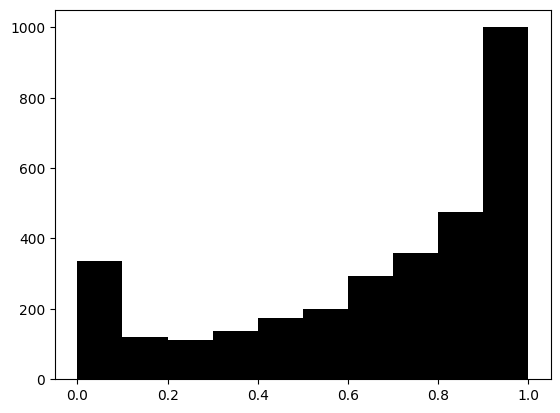

In [11]:
# CREATING A DATAFRAME WITH A MEASURE OF BRODBAND AVAILABILITY FOR EACH COUNTY - DEC 2019


county_bb_2020['P001001'] = pd.to_numeric(county_bb_2020['P001001'], errors='coerce')
county_bb_2020_provision = county_bb_2020.groupby('CountyCode').apply(
    lambda x: pd.Series({
        'county_provision': (x['P001001'] * x['broadband_block']).sum() / x['P001001'].sum()
        if x['P001001'].sum() > 0 else 0
    })
).reset_index()

print(county_bb_2020_provision.head())  
print(len(county_bb_2020_provision)) 
print(county_bb_2020_provision['county_provision'].median())
print((county_bb_2020_provision['county_provision'] == 0).sum())
plt.hist(county_bb_2020_provision['county_provision'], color='black')

In [12]:
county_bb_2020_provision.to_csv(r'..\data\broadband\county_bb_2020.csv', index=False)